# Regression Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split

## Prepare Data

In [3]:
def reconcile_filename_column(df):
    if 'filename' in df.keys():
        df.rename(columns={'filename': 'Filename'}, inplace=True)
    return df

def drop_txt(txt):
    if type(txt) == type(2):
        return txt
    else:
        return(txt.replace('.txt', ''))

def combine_psuedos_with_scores(df, scores_df):
    df = reconcile_filename_column(df)
    df['Filename'] = df['Filename'].apply(drop_txt).astype('int')
    scores_df['Psuedos'] = scores_df['Psuedos'].astype('int')

    combined_df = df.merge(scores_df, how='right', left_on='Filename', right_on='Psuedos')
    combined_df = combined_df.dropna()
    return combined_df

def create_X_y(df, scores_df):
    combined_df = combine_psuedos_with_scores(df, scores_df)

    response_var = combined_df['ChatGPT Percent Score']
    combined_df.drop(['Filename', 'Psuedos', 'ChatGPT Percent Score', 'Response Word Count'], axis=1, inplace=True)
    predictor_vars = combined_df

    return {'X': predictor_vars, 
            'y': response_var
    }

def fit_and_predict(reg, X_train, X_test, y_train, y_test):
    reg.fit(X_train, y_train)
    predictions = reg.predict(X_test)
    reg_r2 = r2_score(y_test, predictions)
    return [reg, reg_r2]

def run_train_test_regression(df_dict, scores_df):
    df_name = df_dict['name']
    try:
        predictor_vars = df_dict['X']
        response_var = df_dict['y']
    except:
        dict_of_info = create_X_y(df_dict['df'], scores_df)
        predictor_vars = dict_of_info['X']
        response_var = dict_of_info['y']

    X_train, X_test, y_train, y_test = train_test_split(predictor_vars, response_var, test_size=0.2)

    lin_reg, lin_reg_r2 = fit_and_predict(LinearRegression(), X_train, X_test, y_train, y_test)
    lasso_reg, lasso_reg_r2 = fit_and_predict(Lasso(), X_train, X_test, y_train, y_test)
    ridge_reg, ridge_reg_r2 = fit_and_predict(Ridge(), X_train, X_test, y_train, y_test)

    return {'name': df_name,
            'response_var': response_var, 
            'predictor_vars': predictor_vars, 
            'linear_reg_r2': round(lin_reg_r2, 3), 
            'lasso_reg_r2': round(lasso_reg_r2, 3),
            'ridge_reg_r2': round(ridge_reg_r2, 3)
            }

def run_cross_val_regression(df_dict, scores_df):
    df_name = df_dict['name']
    try:
        predictor_vars = df_dict['X']
        response_var = df_dict['y']
    except:
        dict_of_info = create_X_y(df_dict['df'], scores_df)
        predictor_vars = dict_of_info['X']
        response_var = dict_of_info['y']

    lin_cross_val_score = cross_val_score(LinearRegression(), predictor_vars, response_var, cv=5, scoring='r2')
    lasso_cross_val_score = cross_val_score(Lasso(), predictor_vars, response_var, cv=5, scoring='r2')
    ridge_cross_val_score = cross_val_score(Ridge(alpha=0.5), predictor_vars, response_var, cv=5, scoring='r2')

    return {'name': df_name,
            'response_var': response_var, 
            'predictor_vars': predictor_vars, 
            'linear_reg_r2': round(lin_cross_val_score.mean(), 3), 
            'lasso_reg_r2': round(lasso_cross_val_score.mean(), 3),
            'ridge_reg_r2': round(ridge_cross_val_score.mean(), 3)
            }

def print_reg_results(dict_of_results):
    print(f'{dict_of_results["name"]}')
    print(f'Linear R2: {dict_of_results["linear_reg_r2"]}')
    print(f'Lasso R2: {dict_of_results["lasso_reg_r2"]}')
    print(f'Ridge R2: {dict_of_results["ridge_reg_r2"]}')
    print()

## Run initial regression analysis

In [4]:
def load_dfs(math=None):
    scores_df = pd.read_excel('combined_responses_scores_added.xlsx', index_col=0)
    scores_df = scores_df[['Psuedos', 'ChatGPT Percent Score', 'Response Word Count', 'Course']]
    if math == None:
        scores_df = scores_df[scores_df['Course'] != 'MATH 111']
    
    scores_df = scores_df.drop(['Course'], axis=1)

    list_of_df_dicts = []

    for pred_name in ['taaco', 'taaled', 'taales', 'taassc']:
        temp_df = pd.read_csv(f'./predictor_results/{pred_name}_results.csv')

        temp_X_y_dict = create_X_y(temp_df, scores_df)
        temp_df_dict = {
            'name': pred_name, 
            'df': temp_df, 
            'X': temp_X_y_dict['X'], 
            'y': temp_X_y_dict['y']
        }
        list_of_df_dicts.append(temp_df_dict)
    return [list_of_df_dicts, scores_df]

In [4]:
list_of_df_dicts, scores_df = load_dfs()

list_of_regression_dicts = []

for df_dict in list_of_df_dicts:
    regression_dict = run_train_test_regression(df_dict, scores_df)
    list_of_regression_dicts.append(regression_dict)

for reg_dict in list_of_regression_dicts:
    print_reg_results(reg_dict)

taaco
Linear R2: -0.133
Lasso R2: -0.015
Ridge R2: 0.113

taaled
Linear R2: -0.197
Lasso R2: -0.019
Ridge R2: -0.08

taales
Linear R2: -6.274
Lasso R2: 0.201
Ridge R2: -0.563

taassc
Linear R2: -3.377
Lasso R2: -0.033
Ridge R2: -0.766



C:\Users\dcham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.278e-02, tolerance: 1.154e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\dcham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.729e-01, tolerance: 1.151e-04
  model = cd_fast.enet_coordinate_descent(


## PCA to reduce dimensionality

In [5]:
from sklearn.decomposition import PCA

def perform_pca(df_dict, n_components):
    pca = PCA(n_components=n_components, svd_solver='full')
    new_X = pca.fit(df_dict['X']).transform(df_dict['X'])
    df_dict['full_X'] = df_dict['X']
    df_dict['X'] = new_X
    return df_dict

list_of_df_dicts, scores_df = load_dfs()

pca_reg_list = []

for df_dict in list_of_df_dicts:
    df_dict = perform_pca(df_dict, 3)
    regression_dict = run_cross_val_regression(df_dict, scores_df)
    pca_reg_list.append(regression_dict)

for reg_dict in pca_reg_list:
    print_reg_results(reg_dict)

taaco
Linear R2: -0.125
Lasso R2: -0.076
Ridge R2: -0.11

taaled
Linear R2: -0.157
Lasso R2: -0.08
Ridge R2: -0.157

taales
Linear R2: -0.189
Lasso R2: -0.189
Ridge R2: -0.189

taassc
Linear R2: -0.078
Lasso R2: -0.078
Ridge R2: -0.078



## Final Combo try

In [6]:
list_of_df_dicts, scores_df = load_dfs()

new_list = []
for df_dict in list_of_df_dicts:
    df_dict = perform_pca(df_dict, 3)
    new_list.append(df_dict)

word_count_series = combine_psuedos_with_scores(new_list[0]['df'], scores_df)[['Response Word Count']].reset_index()

pca_1 = pd.DataFrame(new_list[2]['X'], columns=['pca_1_v0', 'pca_1_v1', 'pca_1_v2'])
pca_2 = pd.DataFrame(new_list[3]['X'], columns=['pca_2_v0', 'pca_2_v1', 'pca_2_v2'])

combo_df = pca_1.join(pca_2, how='inner')

combo_df = combo_df.join(word_count_series, how='inner')

combo_df_dict = {
    'name': 'combo predictors',
    'X': combo_df, 
    'y': new_list[0]['y']
}

combo_reg_dict = run_cross_val_regression(combo_df_dict, scores_df)
print_reg_results(combo_reg_dict)

combo predictors
Linear R2: -0.083
Lasso R2: -0.074
Ridge R2: -0.083



## Factor Analysis to overcome poor linear regression

In [7]:
def factor_analysis_basic_results(df, df_name):
    # Step 1: Adequecy Test
    from factor_analyzer import FactorAnalyzer
    from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    chi_square_value, p_value

    #p-value 0, so observed correlation matrix is not identity

    if p_value < 0.01:
        print(f"Bartlett's test of sphericity suggests the observed correlation matrix is not an identity matrix (p-value={round(p_value, 4)}).")
        from factor_analyzer.factor_analyzer import calculate_kmo
        kmo_all,kmo_model=calculate_kmo(df)
        if kmo_model > 0.6:
            print(f'KMO Test suggests factor analysis is appropriate (KMO={round(kmo_model, 2)}).')
            print('\nFactor Analysis is appropriate with this data.\n')
        else:
            print(f'KMO Test suggests factor analysis is not appropriate (KMO={round(kmo_model, 2)}).')
            print('\nFactor Analysis is not appropriate with this data.\n')
    else:
        print(f"Observed correlation matrix is potentially an identity matrix and thus no factor analysis should be performed.")

    # Step 2: Calculate Number of Factors
    fa = FactorAnalyzer()
    fa.fit(df)
    ev, v = fa.get_eigenvalues()
    n_factors = len(np.where(ev > 1)[0])
    print(ev)
    print(f'Suggested number of factors: {n_factors}')
    
    # Create scree plot using matplotlib
    plt.scatter(range(1,df.shape[1]+1),ev)
    plt.plot(range(1,df.shape[1]+1),ev)
    plt.title('Scree Plot')
    plt.xlabel('Factors')
    plt.ylabel('Eigenvalue')
    plt.grid()
    plt.show()

    # Step 2.5: Different Analysis than Suggested Factor?
    #force_n_factors = int(input('What number of factors do you want to calculate the loading matrix for?'))

    # Step 3: Create Factor Loading Matrix
    fa.set_params(n_factors=n_factors, rotation='promax')
    fa.fit(df)
    loadings = fa.loadings_
    loading_df = pd.DataFrame(loadings).round(4)
    for col_name in loading_df.columns:    
        loading_df[col_name] = np.where(loading_df[col_name] < 0.4, '', loading_df[col_name])
    loading_df['variables'] = df.columns
    loading_df.set_index('variables', drop=True, inplace=True)
    loading_df.to_excel(f'loadings_{df_name}.xlsx')

    # Step 4: Total Variance Explained by Factors
    fa.get_factor_variance()
    # Sum of second row is total % cumulative variance explained by the N factors
    total_variance_explained = fa.get_factor_variance()[1].sum()
    print(f'\n{int(round(total_variance_explained*100, 0))}% cumulative variance explained by the {n_factors} factors')

Observed correlation matrix is potentially an identity matrix and thus no factor analysis should be performed.
[ 8.27089657e+00  6.69709335e+00  1.56060359e+00  6.88765091e-01
  2.24376816e-01  1.79404219e-01  1.39057403e-01  8.01510299e-02
  4.30916345e-02  4.06213894e-02  3.00445956e-02  2.67252805e-02
  1.53294770e-02  2.86290113e-03  6.54012344e-04  3.22645978e-04
  1.52714404e-15 -3.82608186e-16]
Suggested number of factors: 3


C:\Users\dcham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\factor_analyzer\factor_analyzer.py:109: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


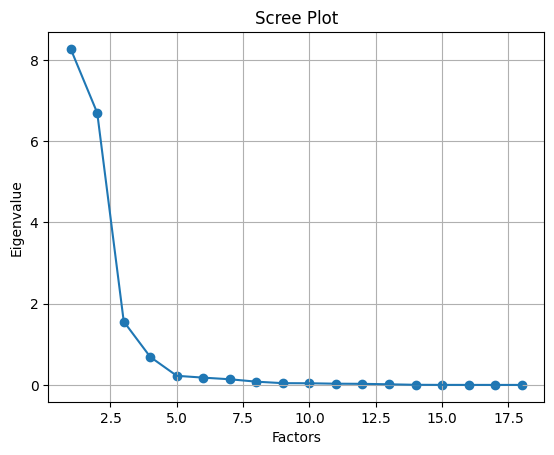


89% cumulative variance explained by the 3 factors


In [8]:
list_of_df_dicts, scores_df = load_dfs()

temp_reg_dict = list_of_df_dicts[1]
factor_analysis_basic_results(temp_reg_dict['X'], temp_reg_dict['name'])

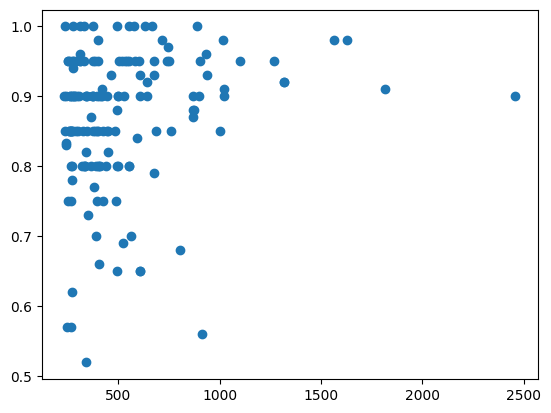

In [6]:
list_of_df_dicts, scores_df = load_dfs()
X = scores_df['Response Word Count']
y = scores_df['ChatGPT Percent Score']

plt.scatter(X, y)

(array([ 2.,  2.,  5.,  4.,  6., 19., 29., 36., 36., 19.]),
 array([0.52 , 0.568, 0.616, 0.664, 0.712, 0.76 , 0.808, 0.856, 0.904,
        0.952, 1.   ]),
 <BarContainer object of 10 artists>)

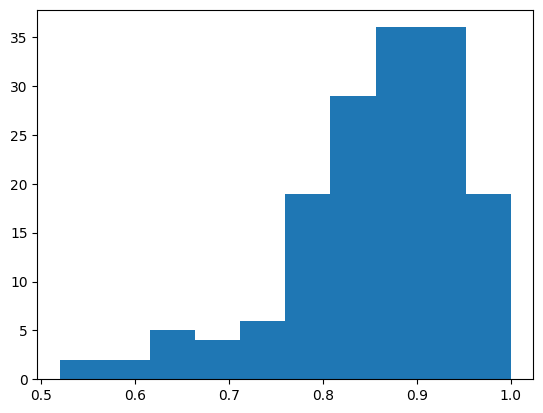

In [8]:
plt.hist(y)

In [19]:
from sklearn.model_selection import cross_val_score

def random_half_point():
    # randomly return 1, 0.95, 0.9, 0.85, 0.8, 0.75
    return np.random.choice([1, 0.95, 0.9, 0.85, 0.8, 0.75])

list_of_df_dicts, scores_df = load_dfs()
guess_df = scores_df['ChatGPT Percent Score']

y = scores_df['ChatGPT Percent Score'].dropna()
X = np.array([random_half_point() for index in range(0, len(y))]).reshape(-1,1)

model_conversion_dict = {
    'linear': LinearRegression(),
    'ridge': Ridge(),
    'lasso': Lasso()
}

for model_type in model_conversion_dict.keys():
    all_scores = cross_val_score(model_conversion_dict[model_type], X, y, cv=5)
    print(f'Model: {model_type}, Avg Score: {round(np.mean(all_scores), 2)}')

Model: linear, Avg Score: -0.09
Model: ridge, Avg Score: -0.08
Model: lasso, Avg Score: -0.08


[np.float64(1.0),
 np.float64(0.95),
 np.float64(0.9),
 np.float64(0.95),
 np.float64(0.85),
 np.float64(0.85),
 np.float64(0.75),
 np.float64(0.95),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.95),
 np.float64(0.8),
 np.float64(0.85),
 np.float64(1.0),
 np.float64(0.85),
 np.float64(0.85),
 np.float64(0.95),
 np.float64(0.75),
 np.float64(0.9),
 np.float64(0.95),
 np.float64(0.95),
 np.float64(0.75),
 np.float64(0.85),
 np.float64(0.9),
 np.float64(0.9),
 np.float64(0.85),
 np.float64(1.0),
 np.float64(0.9),
 np.float64(0.9),
 np.float64(0.85),
 np.float64(0.85),
 np.float64(0.95),
 np.float64(0.85),
 np.float64(0.85),
 np.float64(0.8),
 np.float64(1.0),
 np.float64(0.95),
 np.float64(1.0),
 np.float64(0.85),
 np.float64(0.8),
 np.float64(0.95),
 np.float64(1.0),
 np.float64(0.9),
 np.float64(1.0),
 np.float64(0.75),
 np.float64(1.0),
 np.float64(0.85),
 np.float64(0.95),
 np.float64(0.85),
 np.float64(0.9),
 np.float64(0.85),
 np.float64(0.85),
 np.float64(0.8),
 np.float64(0.8